In [314]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [315]:
# Create gym environment
env = gym.make('Pendulum-v0')

In [316]:
"""
    Here we sample our data and store it in a tensor.
    The tensor will later be used by a neural network for regression.    
"""

rewards = []

def sample(epochs):
    state = env.reset()
    # Array storing samples of 'old state' (3-dim) and 'action' (1-dim)
    x = np.zeros((epochs, 4))
    # Array storing samples of 'new state' (3-dim) and 'reward' (1-dim)
    y = np.zeros((epochs, 4))
    for epoch in range(epochs):
        # Random 'action' sampling
        action = env.action_space.sample()
        # Store 'old state'
        old_state = state
        # Store in array
        x[epoch] = np.array([old_state[0], old_state[1], old_state[2], action])
        # Observations, including 'new state' and 'reward'
        state, reward, done, info = env.step(action)
        # Store in array
        y[epoch] = np.array([state[0], state[1], state[2], reward])
        
        rewards.append(reward)
        #env.render()
    # Transform numpy arrays to tensors
    x = Variable(torch.from_numpy(x), requires_grad=True)
    y = Variable(torch.from_numpy(y), requires_grad=True)
    plt.figure()
    plt.plot(np.array(rewards), label = "Reward per Episode")
    plt.legend()
    return x, y

In [317]:
"""
    Our neural network model used for regression for the reward function and the transition dynamics.
    Also defining its hyperparameters, the loss function and the optimizer-method.
    
"""


class ControlNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ControlNet, self).__init__()
        self.input = torch.nn.Linear(input_dim, hidden_dim1)
        self.fc1 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.output = torch.nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = self.input(x)
        x = self.fc1(x)
        x = self.output(x)
        return x    
    
# Batch size, input dimension, hidden dimension, , hidden dimension, output dimension
batch_size, d_in, d_hid1, d_hid2, d_out = 1, 4, 16, 16, 1 

# Learning rate for backprop
l_rate = 0.05

# Criterion for optimisation: Mean Squared Loss
criterion = torch.nn.MSELoss()

# Instanciate the model
model = ControlNet(d_in, d_hid1, d_hid2, d_out).double()

# Optimizer: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=l_rate)

In [318]:
"""
    Method for shuffling a dataset. Used to preprocess the sample data.
    Takes input and output data as input to shuffle them to same indexes.
    'shuffle_amount' defines how many rows are randomly shuffled.
    If Null is gives, it equals the amount of samples.
    
"""
def shuffle(x, y, shuffle_amount):
    # We only consider first dimension for shuffling
    x_size = list(x.size())[0]
    y_size = list(y.size())[0]
    if shuffle_amount == None:
        shuffle_amount = x_size
    if x_size != y_size:
        print("Input and output sample sizes do not match!")
    else:
        for i in range(shuffle_amount):
            a = np.random.randint(low=0, high=x_size-1)
            b = np.random.randint(low=0, high=x_size-1)
            buffer_x = x[a, :].clone()
            buffer_y = y[a, :].clone()
            x[a, :] = x[b, :]
            y[a, :] = y[b, :]
            x[b, :] = buffer_x
            y[b, :] = buffer_y

            
            

Sampling...
...done

Learning...
...done


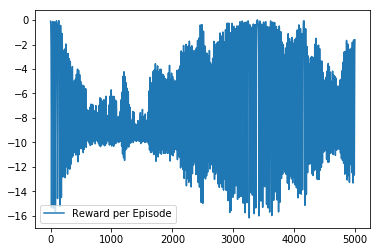

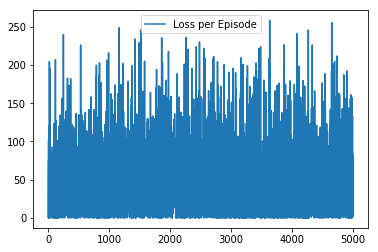

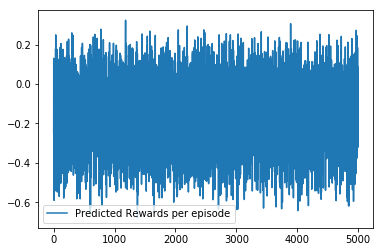

In [319]:
"""
    Training our neural network with the pre-sampled data.

"""
# Arrays for plotting fun stuff
plot = []
predicted_rewards = []

samples = 5000

print("Sampling...")
x, y = sample(epochs=samples)
shuffle(x, y, shuffle_amount=None)
print("...done")
print()

print("Learning...")
for i in range(int(samples/batch_size)):
    # Forward pass of minibatch
    prediction = model.forward(x[i*batch_size:(i+1)*batch_size,:])
    predicted_rewards.append(prediction)
    # Calculate the loss
    loss = Variable(criterion(prediction, y[i*batch_size:(i+1)*batch_size,-1]), requires_grad=True)
    plot.append(loss)

    # Clear gradients, backpropagation and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print("...done")
plot = np.array(plot)
predicted_reward = np.array(predicted_rewards)


# Close rendering
env.close()

# Plot loss
plt.figure()
plt.plot(plot, label="Loss per Episode")
plt.legend()

plt.figure()
plt.plot(predicted_rewards, label="Predicted Rewards per episode")
plt.legend()
plt.show()
